The goal here is to remove a link at some point in the simulation, and to visualize how the application was re-reouted in response. 

Thoughts: 

it is not obvious where in the code base to put the removal of a link. Options:
1. resource_management_algorithm, the function that goes into the simulator, gets called each timestep. Thus it is a good candidate. 
    - but this conceptually conflates human management of a resource with non-human chaotic unavailability of a resource. 
2. The simulator.sceduler object is meant to schedule when the various agents take their step actions. 
    - user.step only goes through apps and re-sets-commuication paths if the user has moved. Thus, as is, as long as a user stays in one place after a link is removed, the user is running an app that flows through a removed link. 
    - Thus, it seems like the right thing to do is to re-evaluate link paths at all time steps. I'm tempted to ask if there should be some cost associated with changing the flow. There is a natural cost of additional delay, and of energy use for the additional ports. Other than that, I think it should be ok to re-evaluate the flow for each applicatioon for each user at each timestep. Though, this might add up to a lot of real world computation time. 


3. The simulator object has an optional `user_defined_functions` list. I presume that such a function is run at each timestep. 
    - aparently it does not. Seemingly, it just makes the function a global variable.
        - i will use this by simply adding a line calling my link removal function within the resource management algorithm.

# Initialize model with user defined removal schedule. 

removing NetworkLink_12


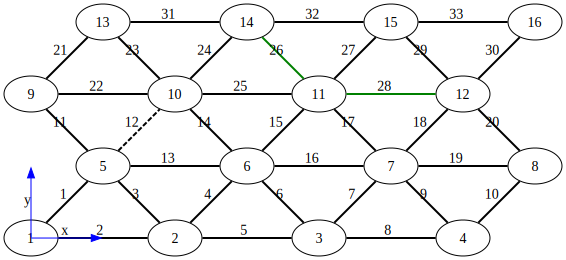

In [4]:
import edge_sim_py as esp

def remove_link_12_at_t(t=30):
    if simulator.schedule.time == t :
        print(f"removing {esp.NetworkLink.all()[11]}")
        link = esp.NetworkLink.all()[11]
        link.active = False
        link.delay = float('inf')
        link.failed = True
        
def place_and_migrate_to_least_utilized(parameters):
    remove_link_12_at_t(t=30)
    for service in esp.Service.all():
        if not service.being_provisioned:
            edge_servers = sorted(
                esp.EdgeServer.all(), key=lambda s: (
                    (s.cpu - s.cpu_demand) 
                   * (s.memory - s.memory_demand) 
                   * (s.disk - s.disk_demand)
                  ) ** (1/3),
                reverse=True,
            )
            for edge_server in edge_servers: # use ordered list
                if edge_server.has_capacity_to_host(service=service):
                    if service.server != edge_server:
                        # print(f"[STEP {parameters['current_step']}] Migrating {service} From {service.server} to {edge_server}")
                        service.provision(target_server=edge_server)
                        break

def stop_on_n_steps(model: object,n=31):    
    return model.schedule.steps == n

simulator = esp.Simulator(tick_duration=1,tick_unit="seconds",
    stopping_criterion=stop_on_n_steps,
    resource_management_algorithm=place_and_migrate_to_least_utilized,
    user_defined_functions=[remove_link_12_at_t]
)
simulator.initialize(input_file="../edgesimpy-tutorials/datasets/sample_dataset2.json")
simulator.run_model()

user = esp.User.all()[5]
path = user.communication_paths[str(user.applications[0].id)][0]

def path_to_edge_filter(path):
    path_edges_by_id = [{str(path[i]),str(path[i+1])} for i in range(len(path) -1 )]
    edge_filter = [ {str(node.id) for node in edge.nodes} in path_edges_by_id 
              for edge in esp.NetworkLink.all()]
    return edge_filter

simulator.visualize(path_to_edge_filter(path))

It seems that in the 30 steps after removal of the link, a new path was not set. So... it seems that the set_communication_path method is not called upon the model stepping. 

`simulator.step()` calls `simulator.schedule.step()`. The default value for `simulator.schedule` is an instance of `DefaultScheduler` 

In [3]:
user.base_station

BaseStation_14